In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import OrdinalEncoder

import os
import warnings

from abc import ABC, abstractmethod

warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

%matplotlib inline

In [2]:
!pip install optuna-integration[lightgbm]

# EDA

In [3]:
train = pd.read_csv('/kaggle/input/mai-ml-lab-2-fiit-2025/train_c.csv')
test = pd.read_csv('/kaggle/input/mai-ml-lab-2-fiit-2025/test_c.csv')

In [4]:
test_ids = test['ID']

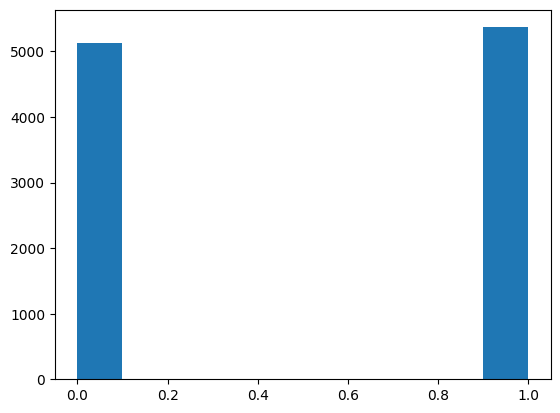

In [5]:
plt.hist(train['LoanApproved'].dropna())
plt.show()

In [34]:
def normalize_z_score(x: pd.Series):
    if isinstance(x, pd.Series):
        std = x.std()
        if np.isnan(std) or std == 0:
            return pd.Series(np.zeros(len(x)), index=x.index)
        
        z_scores = (x - x.mean()) / std
        z_scores = z_scores.replace([np.inf, -np.inf], np.nan)
        return z_scores
    elif isinstance(x, pd.DataFrame):
        return x.apply(normalize_z_score)
    
def normalize_min_max(x: pd.Series):
    mn = x.min()
    mx = x.max()

    return (x - mn) / (mx - mn)

def remove_outliers_z(data: pd.DataFrame, column=None, threshold=5):
    if column is None:
        outliers = normalize_z_score(data).abs() > threshold
    else:
        outliers = normalize_z_score(data[column]).abs() > threshold
    
    return data[~outliers]

def fill_missing_values(df):
    df_filled = df.copy()
    numeric_cols = df_filled.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'RiskScore']
    
    for col in numeric_cols:
        if df_filled[col].isnull().any():
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())
            
    categorical_cols = df_filled.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if df_filled[col].isnull().any():
            mode_value = df_filled[col].mode()[0] if not df_filled[col].mode().empty else 'Unknown'
            df_filled[col] = df_filled[col].fillna(mode_value)
    return df_filled


def process_features(df):
    df_c = df.copy()
    
    df_c.drop('ApplicationDate', axis=1, inplace=True)

    cat_cols = df_c.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df_c[col] = df_c[col].fillna('Missing').astype(str)

    return df_c

In [35]:
target = 'LoanApproved'

train_clean = process_features(train)
train_clean = train_clean.dropna(subset=[target])

test_clean = process_features(test)

X = train_clean.drop(target, axis=1)
y = train_clean[target]
X_test = test_clean.drop(columns=[c for c in ['ID', target] if c in test_clean.columns])

cat_features = list(X.select_dtypes(include=['object']).columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


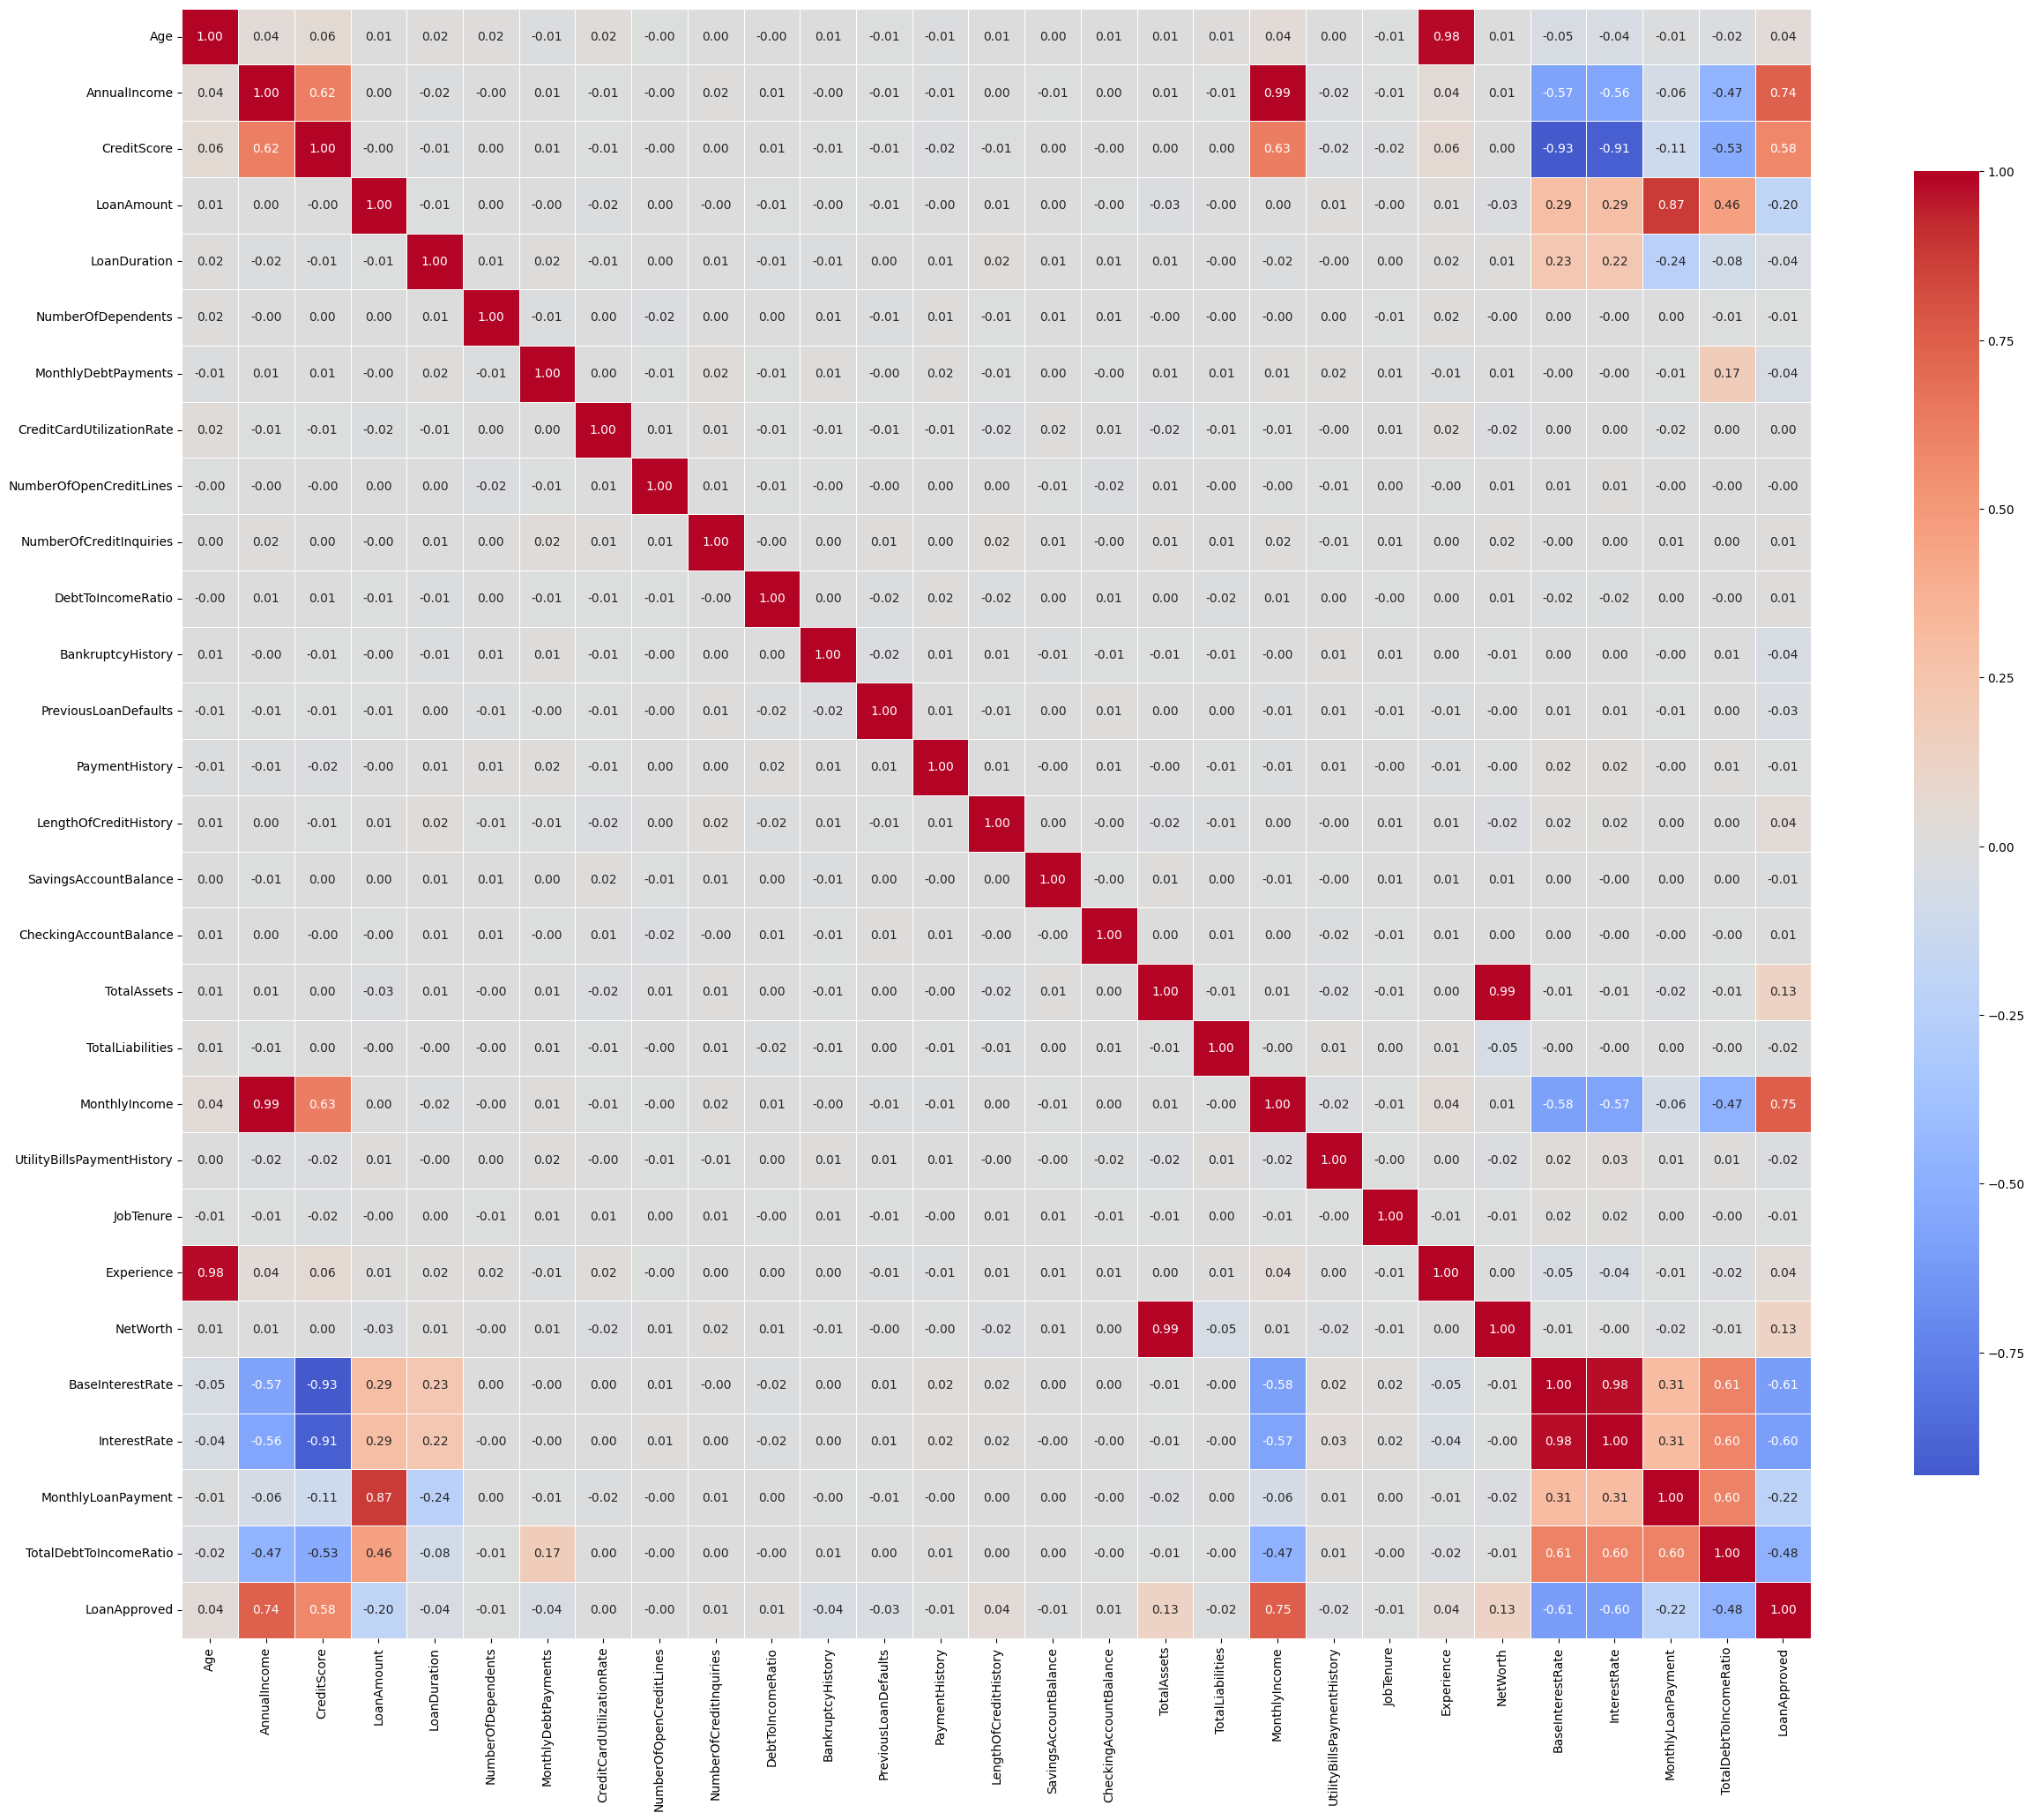

In [36]:
correlation_matrix = train_clean[train_clean.select_dtypes(include=['float64']).columns].corr()

plt.figure(figsize=(30, 24))

sns.heatmap(correlation_matrix, 
            annot=True,           
            cmap='coolwarm',      
            center=0,             
            fmt='.2f',            
            square=True,          
            linewidths=0.5,       
            cbar_kws={'shrink': 0.8})

plt.show()

<Axes: xlabel='LoanApproved', ylabel='count'>

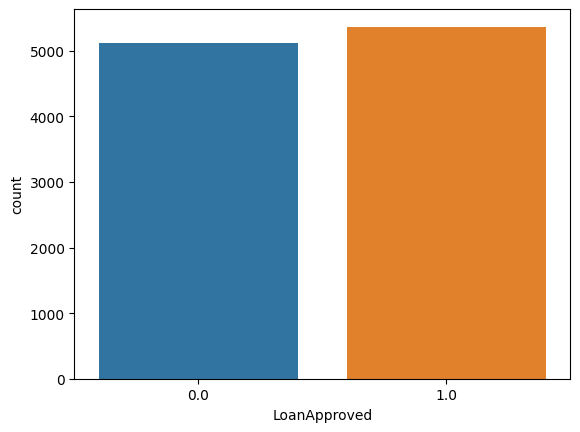

In [9]:
sns.countplot(x='LoanApproved', data=train_clean)

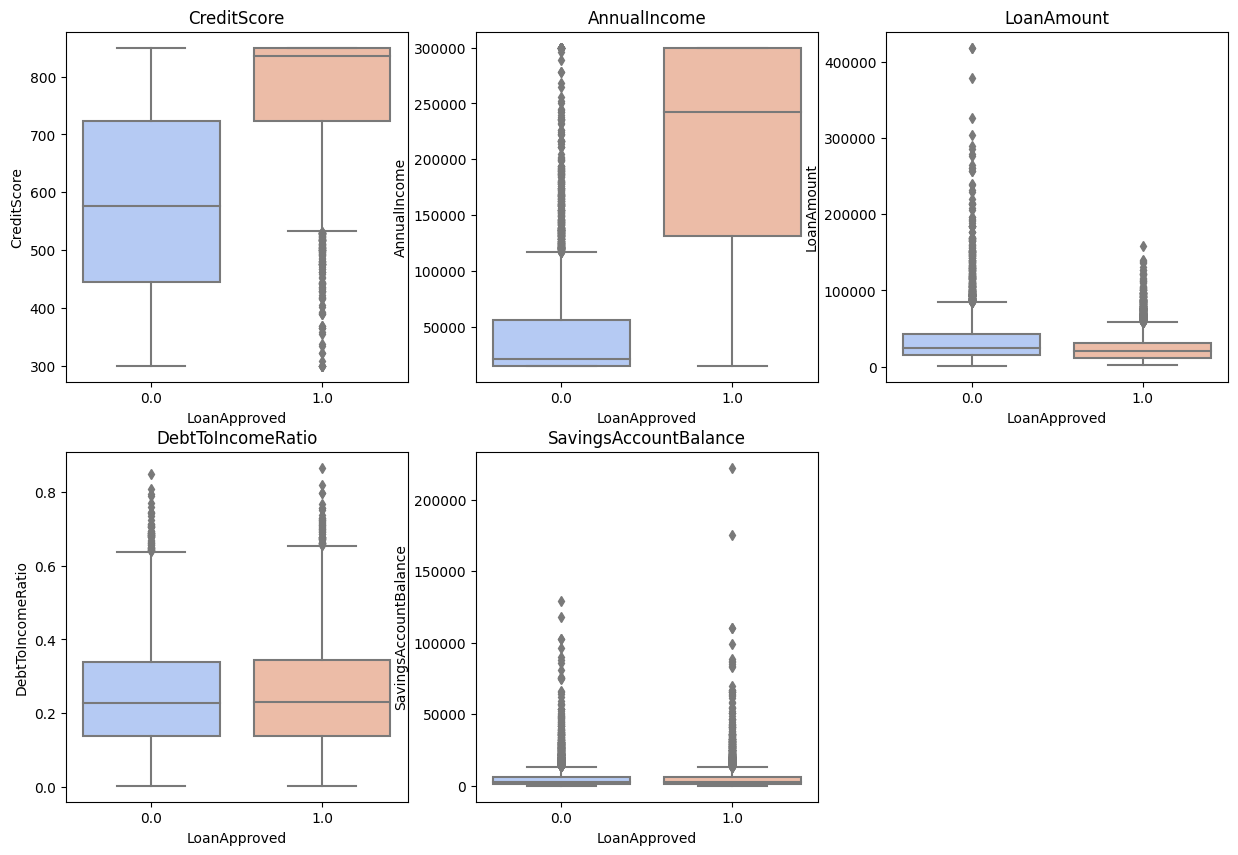

In [10]:
numerical_features = ['CreditScore', 'AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 'SavingsAccountBalance']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='LoanApproved', y=col, data=train_clean, palette='coolwarm')
    plt.title(col)

# Bagging

In [37]:
class Bagging:
    def __init__(self, base_model_class=None, n=5, **model_params):
        if (base_model_class is None):
            raise TypeError()
            
        self.n = n
        self.models = []
        
        for i in range(n):
            self.models.append(base_model_class(**model_params))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        for model in self.models:
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            model.fit(X_bootstrap, y_bootstrap)
            
        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        
        predictions = np.array([model.predict(X) for model in self.models]).T
        
        mean_prediction = np.mean(predictions, axis=1)
        final_predictions = (mean_prediction >= 0.5).astype(int)
        
        return final_predictions

In [38]:
train_clean_ohe = pd.get_dummies(train_clean).dropna()

X_ohe = train_clean_ohe.drop(columns=['LoanApproved'], axis=1)
y_ohe = train_clean_ohe['LoanApproved']

X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe = train_test_split(
    X_ohe, y_ohe, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_ohe
)

In [39]:
N_ESTIMATORS = 10
tree_params = {'max_depth': 10}

print("--- Our Bagging ---")

our_bagging = Bagging(base_model_class=DecisionTreeClassifier, n=N_ESTIMATORS, **tree_params)

our_bagging.fit(X_train_ohe, y_train_ohe)
y_pred_our = our_bagging.predict(X_val_ohe)

print(f"Accuracy: {accuracy_score(y_val_ohe, y_pred_our):.4f}")


print("\n--- Sklearn BaggingClassifier ---")
base_tree = DecisionTreeClassifier(**tree_params)
sklearn_bagging = BaggingClassifier(estimator=base_tree, n_estimators=N_ESTIMATORS, random_state=42)

sklearn_bagging.fit(X_train_ohe, y_train_ohe)
y_pred_sklearn = sklearn_bagging.predict(X_val_ohe)

print(f"Accuracy: {accuracy_score(y_val_ohe, y_pred_sklearn):.4f}")

--- Our Bagging ---
Accuracy: 0.9244

--- Sklearn BaggingClassifier ---
Accuracy: 0.9279


# Boosting

In [40]:
class GradientBoosting:
    def __init__(self, base_model_class=None, n=10, learning_rate=0.1, **model_params):
        if (base_model_class is None):
            raise TypeError()
        
        self.base_model_class = base_model_class
        self.n = n
        self.learning_rate = learning_rate
        self.model_params = model_params
        self.models = []
        self.base_pred = 0.0

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        prob = np.clip(np.mean(y), 1e-10, 1 - 1e-10)
        self.base_pred = np.log(prob / (1 - prob))
        
        current_preds = np.full(y.shape, self.base_pred)

        for _ in range(self.n):
            p = self._sigmoid(current_preds)
            
            residuals = y - p
            
            model = self.base_model_class(**self.model_params)
            model.fit(X, residuals)
            
            update = model.predict(X)
            
            current_preds += self.learning_rate * update
            
            self.models.append(model)
            
        return self

    def predict_proba(self, X):
        X = np.array(X)
        
        preds = np.full(X.shape[0], self.base_pred)
        
        for model in self.models:
            preds += self.learning_rate * model.predict(X)

        prob_class_1 = self._sigmoid(preds)
        prob_class_0 = 1 - prob_class_1
        
        return np.column_stack((prob_class_0, prob_class_1))

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

In [41]:
N_ESTIMATORS = 10
LEARNING_RATE = 0.1
tree_params = {'max_depth': 3, 'random_state': 42}

print("--- Our GradientBoosting ---")
our_gb = GradientBoosting(base_model_class=DecisionTreeRegressor, 
                             n=N_ESTIMATORS, 
                             learning_rate=LEARNING_RATE, 
                             **tree_params)

our_gb.fit(X_train_ohe, y_train_ohe)
y_pred_our = our_gb.predict(X_val_ohe)
y_prob_our = our_gb.predict_proba(X_val_ohe)[:, 1]

print(f"Accuracy: {accuracy_score(y_val_ohe, y_pred_our):.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_val_ohe, y_prob_our):.4f}")


print("\n--- Sklearn GradientBoostingClassifier ---")
sklearn_gb = GradientBoostingClassifier(n_estimators=N_ESTIMATORS,
                                        learning_rate=LEARNING_RATE,
                                        max_depth=3,
                                        random_state=42)

sklearn_gb.fit(X_train_ohe, y_train_ohe)
y_pred_sk = sklearn_gb.predict(X_val_ohe)
y_prob_sk = sklearn_gb.predict_proba(X_val_ohe)[:, 1]

print(f"Accuracy: {accuracy_score(y_val_ohe, y_pred_sk):.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_val_ohe, y_prob_sk):.4f}")

--- Our GradientBoosting ---
Accuracy: 0.9074
ROC-AUC:  0.9690

--- Sklearn GradientBoostingClassifier ---
Accuracy: 0.9164
ROC-AUC:  0.9755


In [42]:
X_train_boost = X_train.copy()
X_val_boost = X_val.copy()

for col in cat_features:
    X_train_boost[col] = X_train_boost[col].astype('category')
    X_val_boost[col] = X_val_boost[col].astype('category')

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_sk = X_train.copy()
X_val_sk = X_val.copy()

X_train_sk[cat_features] = enc.fit_transform(X_train[cat_features])
X_val_sk[cat_features] = enc.transform(X_val[cat_features])

X_train_sk = X_train_sk.fillna(-1)
X_val_sk = X_val_sk.fillna(-1)

In [43]:
models = {
    "Sklearn GBM": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "XGBoost": xgb.XGBClassifier(
        random_state=42, 
        eval_metric='logloss',
        enable_categorical=True, 
        tree_method='hist'
    ),
    "LightGBM": lgb.LGBMClassifier(random_state=15, verbose=-1),
    "CatBoost": CatBoostClassifier(random_state=15, verbose=0, allow_writing_files=False)
}

print(f"{'Model':<15} | {'Accuracy':<10} | {'ROC-AUC':<10}")
print("-" * 55)

for name, model in models.items():
    if name == "Sklearn GBM":
        curr_X_train, curr_X_val = X_train_sk, X_val_sk
        fit_params = {}
        
    elif name in ["XGBoost", "LightGBM"]:
        curr_X_train, curr_X_val = X_train_boost, X_val_boost
        fit_params = {}
        
    elif name == "CatBoost":
        curr_X_train, curr_X_val = X_train, X_val
        fit_params = {'cat_features': cat_features}
        
    model.fit(curr_X_train, y_train, **fit_params)
    
    y_pred = model.predict(curr_X_val)
    y_prob = model.predict_proba(curr_X_val)[:, 1]
    
    acc = accuracy_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_prob)
    
    print(f"{name:<15} | {acc:.4f}     | {roc:.4f}")

Model           | Accuracy   | ROC-AUC   
-------------------------------------------------------
Sklearn GBM     | 0.9323     | 0.9849
XGBoost         | 0.9352     | 0.9852
LightGBM        | 0.9333     | 0.9861
CatBoost        | 0.9371     | 0.9866


In [44]:
X_lgb = X.copy()
X_test_lgb = X_test.copy()
y_lgb = y.copy()

for col in cat_features:
    X_lgb[col] = X_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

X_train_lgb = X_train.copy()
X_val_lgb = X_val.copy()

for col in cat_features:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_val_lgb[col] = X_val_lgb[col].astype('category')

In [45]:
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")

    for train_idx, val_idx in cv.split(X_lgb, y_lgb):
        X_tr, X_val_fold = X_lgb.iloc[train_idx], X_lgb.iloc[val_idx]
        y_tr, y_val_fold = y_lgb.iloc[train_idx], y_lgb.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        preds = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, preds)
        cv_scores.append(score)

    return np.mean(cv_scores)

study_lgb = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
study_lgb.optimize(objective_lgb, n_trials=50)

print(f"Best trial average AUC: {study_lgb.best_value:.5f}")
print("Best params:", study_lgb.best_params)

Best trial average AUC: 0.98555
Best params: {'learning_rate': 0.04145612959254132, 'num_leaves': 605, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.9292748622873769, 'subsample_freq': 3, 'colsample_bytree': 0.5865845268656853, 'reg_alpha': 4.653792518338827e-05, 'reg_lambda': 3.7705972196263885e-08, 'scale_pos_weight': 2.725034608620891}


In [51]:
def objective_cb(trial):
    params = {
        'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False,
        'random_seed': 42,
        'task_type': 'CPU',
        'thread_count': -1,
        'cat_features': cat_features,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        'bootstrap_type': 'Bayesian',
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }
    
    if params['grow_policy'] == 'Lossguide':
         params['max_leaves'] = trial.suggest_int('max_leaves', 16, 64)

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**params)
        
        model.fit(
            X_tr, y_tr,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=50,
            verbose=False
        )
        
        preds = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, preds)
        cv_scores.append(score)

    return np.mean(cv_scores)

study_cb = optuna.create_study(direction='maximize', study_name="CatBoost_Optimization")
study_cb.optimize(objective_cb, n_trials=20)

print(f"Best AUC: {study_cb.best_value:.5f}")
print("Best params:", study_cb.best_params)

Best AUC: 0.98412
Best params: {'learning_rate': 0.02790438444550957, 'depth': 5, 'l2_leaf_reg': 9.933799028549366, 'random_strength': 7.887423544542746, 'bagging_temperature': 0.4650068218182555, 'border_count': 226, 'scale_pos_weight': 2.510031358370627, 'grow_policy': 'Depthwise'}


# Метрики

In [46]:
class Metric(ABC):
    def __init__(self, name: str):
        self.name = name

    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass
    
    def _get_counts(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return TP, TN, FP, FN


class Accuracy(Metric):
    def __init__(self):
        super().__init__("Accuracy")

    def __call__(self, y_true, y_pred):
        TP, TN, FP, FN = self._get_counts(y_true, y_pred)
        return (TP + TN) / (TP + TN + FP + FN + 1e-15)

class Precision(Metric):
    def __init__(self):
        super().__init__("Precision")

    def __call__(self, y_true, y_pred):
        TP, TN, FP, FN = self._get_counts(y_true, y_pred)
        if (TP + FP) == 0: 
            return 0.0
            
        return TP / (TP + FP)

class Recall(Metric):
    def __init__(self):
        super().__init__("Recall")

    def __call__(self, y_true, y_pred):
        TP, TN, FP, FN = self._get_counts(y_true, y_pred)
        if (TP + FN) == 0: 
            return 0.0
            
        return TP / (TP + FN)

class F1Score(Metric):
    def __init__(self):
        super().__init__("F1-Score")

    def __call__(self, y_true, y_pred):
        TP, TN, FP, FN = self._get_counts(y_true, y_pred)
        
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        
        if (prec + rec) == 0: return 0.0
        return 2 * (prec * rec) / (prec + rec)


class RocAuc:
    def __init__(self):
        self.name = "AUC-ROC"

    def __call__(self, y_true, y_score):
        y_true = np.array(y_true)
        y_score = np.array(y_score)

        desc_score_indices = np.argsort(y_score)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        y_score_sorted = y_score[desc_score_indices]

        n_pos = np.sum(y_true == 1)
        n_neg = len(y_true) - n_pos

        if n_pos == 0 or n_neg == 0:
            return 0.5

        distinct_value_indices = np.where(np.diff(y_score_sorted))[0]
        threshold_indices = np.r_[distinct_value_indices, len(y_true_sorted) - 1]

        tps = np.cumsum(y_true_sorted)[threshold_indices]
        fps = (1 + threshold_indices) - tps

        tpr = np.r_[0, tps / n_pos]
        fpr = np.r_[0, fps / n_neg]

        return np.trapz(tpr, fpr)

class PrAuc:
    def __init__(self):
        self.name = "AUC-PR"

    def __call__(self, y_true, y_score):
        y_true = np.array(y_true)
        y_score = np.array(y_score)

        desc_score_indices = np.argsort(y_score)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        y_score_sorted = y_score[desc_score_indices]

        n_pos = np.sum(y_true)
        if n_pos == 0:
            return 0.0

        distinct_value_indices = np.where(np.diff(y_score_sorted))[0]
        threshold_indices = np.r_[distinct_value_indices, len(y_true_sorted) - 1]

        tps = np.cumsum(y_true_sorted)[threshold_indices]
        fps = (1 + threshold_indices) - tps

        precision = tps / (tps + fps)
        recall = tps / n_pos

        precision = np.r_[1, precision]
        recall = np.r_[0, recall]

        return np.trapz(precision, recall)

In [47]:
y_pred_class = our_gb.predict(X_val_ohe)

y_pred_proba = our_gb.predict_proba(X_val_ohe)[:, 1]

print(f"\n{'Metric':<15} | {'Our':<20}   | {'Sklearn':<20}")
print("-" * 75)

metrics_config = [
    (Accuracy(), accuracy_score, False),
    (Precision(), precision_score, False),
    (Recall(), recall_score, False),
    (F1Score(), f1_score, False),
    (RocAuc(), roc_auc_score, True)
]

for metric_obj, sk_func, is_proba in metrics_config:
    pred = y_pred_proba if is_proba else y_pred_class
    
    my_val = metric_obj(y_val_ohe, pred)
    sk_val = sk_func(y_val_ohe, pred)
    
    print(f"{metric_obj.name:<15} | {my_val:.8f}             | {sk_val:.8f}")

pr_auc_metric = PrAuc()
my_pr_auc = pr_auc_metric(y_val_ohe, y_pred_proba)

sk_prec, sk_rec, _ = precision_recall_curve(y_val_ohe, y_pred_proba)
sk_pr_auc = auc(sk_rec, sk_prec)

print(f"{pr_auc_metric.name:<15} | {my_pr_auc:.8f}             | {sk_pr_auc:.8f}")


Metric          | Our                    | Sklearn             
---------------------------------------------------------------------------
Accuracy        | 0.90740741             | 0.90740741
Precision       | 0.89687796             | 0.89687796
Recall          | 0.92578125             | 0.92578125
F1-Score        | 0.91110043             | 0.91110043
AUC-ROC         | 0.96904878             | 0.96904878
AUC-PR          | 0.97089690             | 0.97089690


# Обучение

In [48]:
lgb_params = study_lgb.best_params.copy()

lgb_params['objective'] = 'binary'
lgb_params['metric'] = 'auc'
lgb_params['random_state'] = 42
lgb_params['n_jobs'] = -1
lgb_params['verbosity'] = -1

lgb_params['n_estimators'] = 2000

model_lgb = lgb.LGBMClassifier(**lgb_params)

model_lgb.fit(X_lgb, y_lgb)

LGBMClassifier(colsample_bytree=0.5865845268656853,
               learning_rate=0.04145612959254132, max_depth=4, metric='auc',
               min_child_samples=23, n_estimators=2000, n_jobs=-1,
               num_leaves=605, objective='binary', random_state=42,
               reg_alpha=4.653792518338827e-05,
               reg_lambda=3.7705972196263885e-08,
               scale_pos_weight=2.725034608620891, subsample=0.9292748622873769,
               subsample_freq=3, verbosity=-1)

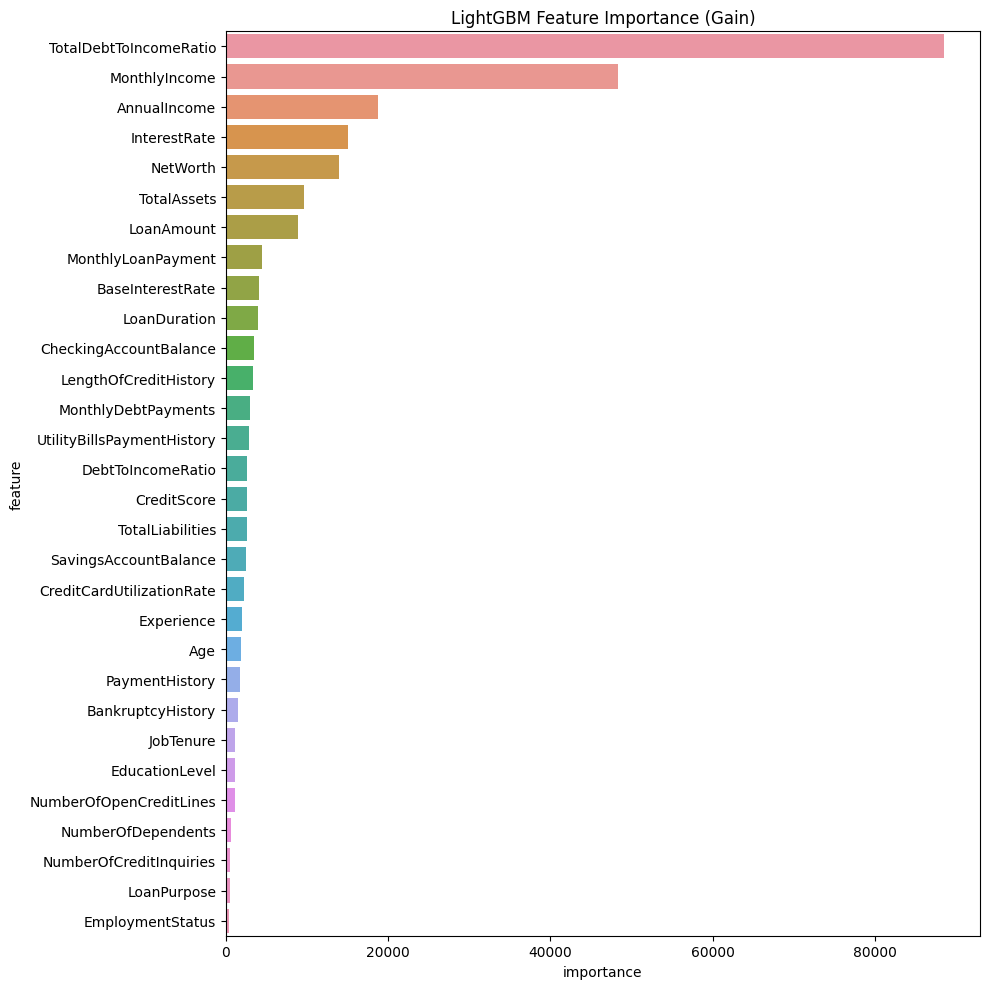

In [49]:
plt.figure(figsize=(10, 10))
feature_imp = pd.DataFrame({
    'importance': model_lgb.booster_.feature_importance(importance_type='gain'), 
    'feature': X_lgb.columns
})

sns.barplot(x='importance', y='feature', data=feature_imp.sort_values(by='importance', ascending=False).head(30))
plt.title("LightGBM Feature Importance (Gain)")
plt.tight_layout()
plt.show()

In [50]:
test_predictions_lgb = model_lgb.predict_proba(X_test_lgb)[:, 1]

submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions_lgb
})

print(submission.head(20))

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен.")

    ID  LoanApproved
0    0  9.999823e-01
1    1  9.874871e-04
2    2  9.999948e-01
3    3  9.999960e-01
4    4  9.999899e-01
5    5  4.493514e-05
6    6  9.999993e-01
7    7  9.999635e-01
8    8  9.605747e-01
9    9  5.883873e-07
10  10  9.957443e-01
11  11  9.119412e-01
12  12  2.784986e-01
13  13  9.999955e-01
14  14  9.990909e-01
15  15  1.816398e-03
16  16  1.000000e+00
17  17  9.998769e-01
18  18  5.852444e-06
19  19  2.167059e-08
Файл submission.csv успешно сохранен.


In [54]:
final_params = study_cb.best_params.copy()

final_params.update({
    'iterations': 2000,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 200, 
    'cat_features': cat_features
})

model_cb = CatBoostClassifier(**final_params)

model_cb.fit(
    X, y
)

0:	total: 18.2ms	remaining: 3m 2s
200:	total: 2.79s	remaining: 2m 15s
400:	total: 5.63s	remaining: 2m 14s
600:	total: 8.53s	remaining: 2m 13s
800:	total: 11.2s	remaining: 2m 8s
1000:	total: 13.9s	remaining: 2m 5s
1200:	total: 16.8s	remaining: 2m 2s
1400:	total: 19.5s	remaining: 1m 59s
1600:	total: 22.4s	remaining: 1m 57s
1800:	total: 25.2s	remaining: 1m 54s
2000:	total: 28.1s	remaining: 1m 52s
2200:	total: 30.8s	remaining: 1m 49s
2400:	total: 33.5s	remaining: 1m 45s
2600:	total: 36s	remaining: 1m 42s
2800:	total: 38.7s	remaining: 1m 39s
3000:	total: 41.2s	remaining: 1m 36s
3200:	total: 44s	remaining: 1m 33s
3400:	total: 46.6s	remaining: 1m 30s
3600:	total: 49.2s	remaining: 1m 27s
3800:	total: 51.8s	remaining: 1m 24s
4000:	total: 54.3s	remaining: 1m 21s
4200:	total: 56.9s	remaining: 1m 18s
4400:	total: 59.2s	remaining: 1m 15s
4600:	total: 1m 1s	remaining: 1m 11s
4800:	total: 1m 3s	remaining: 1m 8s
5000:	total: 1m 5s	remaining: 1m 5s
5200:	total: 1m 7s	remaining: 1m 2s
5400:	total: 1m 9s

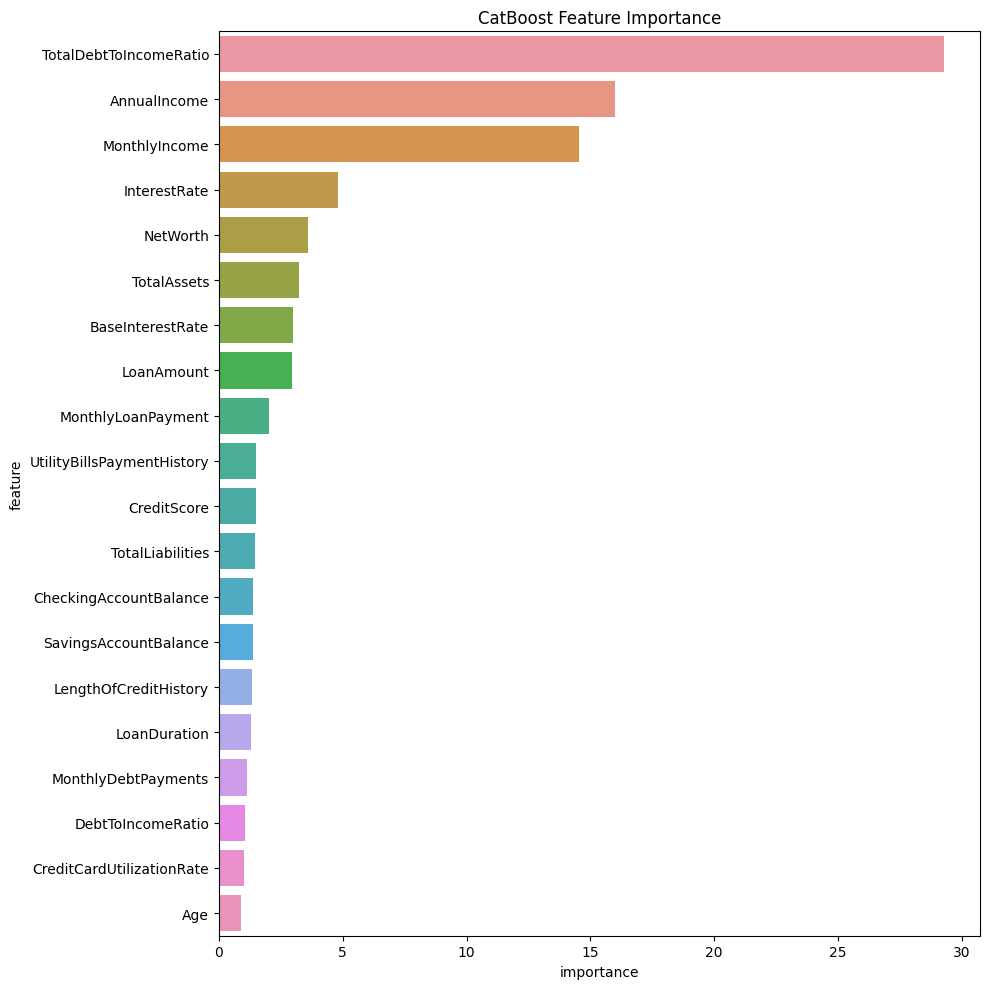

In [55]:
plt.figure(figsize=(10, 10))
feature_imp = pd.DataFrame({
    'importance': model_cb.get_feature_importance(),
    'feature': X.columns
})
sns.barplot(x='importance', y='feature', data=feature_imp.sort_values(by='importance', ascending=False).head(20))
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

In [56]:
test_predictions_cb = model_cb.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions_cb
})

submission.to_csv('submission_catboost.csv', index=False)
print("Файл submission_catboost.csv сохранен.")

Файл submission_catboost.csv сохранен.
